In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

For this project, we will only be using a very small subset of the data to do our analysis. This is not something one would usually do in practice, but is something we do for this project to simplify this complexity of this dataset. The data is pretty noisy and to get meaningful results to demonstrate the theoretical behavior, you would need to use a much more complicated set of features that would be a bit more tedious to work with.

In [2]:
sales = pd.read_csv('home_data.csv') 

# Selects 1% of the data
sales = sales.sample(frac=0.01, random_state=0) 

print(f'Number of points: {len(sales)}')
sales.head()

Number of points: 216


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17384,1453602313,20141029T000000,297000,2,1.50,1430,1650,3.0,0,0,...,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
722,2225059214,20140808T000000,1578000,4,3.25,4670,51836,2.0,0,0,...,12,4670,0,1988,0,98005,47.6350,-122.164,4230,41075
2680,2768000270,20140625T000000,562100,2,0.75,1440,3700,1.0,0,0,...,7,1200,240,1914,0,98107,47.6707,-122.364,1440,4300
18754,6819100040,20140624T000000,631500,2,1.00,1130,2640,1.0,0,0,...,8,1130,0,1927,0,98109,47.6438,-122.357,1680,3200
14554,4027700666,20150426T000000,780000,4,2.50,3180,9603,2.0,0,2,...,9,3180,0,2002,0,98155,47.7717,-122.277,2440,15261


First, we do a bit of feature engineering by creating features that represent the squares of each feature and the square root of each feature. One benefit of using regularization is you can include more features than necessary and you don't have to be as worried about overfitting since the model is regularized.

In [3]:
from math import sqrt

# All of the features of interest
features = [
    'bedrooms', 
    'bathrooms',
    'sqft_living', 
    'sqft_lot', 
    'floors', 
    'waterfront', 
    'view', 
    'condition', 
    'grade',
    'sqft_above',
    'sqft_basement',
    'yr_built', 
    'yr_renovated'
]

# Compute the square and sqrt of each feature
all_features = []
for feat in features:
    square_feat = feat + '_square'
    sqrt_feat = feat + '_sqrt'
    
    sales[square_feat] = sales[feat] ** 2
    sales[sqrt_feat] = sales[feat].apply(sqrt)
    
    all_features.extend([feat, square_feat, sqrt_feat])
    
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade_square,grade_sqrt,sqft_above_square,sqft_above_sqrt,sqft_basement_square,sqft_basement_sqrt,yr_built_square,yr_built_sqrt,yr_renovated_square,yr_renovated_sqrt
17384,1453602313,20141029T000000,297000,2,1.50,1430,1650,3.0,0,0,...,49,2.645751,2044900,37.815341,0,0.000000,3996001,44.710178,0,0.0
722,2225059214,20140808T000000,1578000,4,3.25,4670,51836,2.0,0,0,...,144,3.464102,21808900,68.337398,0,0.000000,3952144,44.586994,0,0.0
2680,2768000270,20140625T000000,562100,2,0.75,1440,3700,1.0,0,0,...,49,2.645751,1440000,34.641016,57600,15.491933,3663396,43.749286,0,0.0
18754,6819100040,20140624T000000,631500,2,1.00,1130,2640,1.0,0,0,...,64,2.828427,1276900,33.615473,0,0.000000,3713329,43.897608,0,0.0
14554,4027700666,20150426T000000,780000,4,2.50,3180,9603,2.0,0,2,...,81,3.000000,10112400,56.391489,0,0.000000,4008004,44.743715,0,0.0


We first need to do a little bit more pre-processing to prepare the data for model training. Models like Ridge and LASSO assume the input features are standardized (mean 0, std. dev. 1) and the target values are centered (mean 0). If we do not do this, we might get some unpredictable results since we violate the assumption of the models!

In [4]:
def standardize(v):
    """
    Takes a single column of a DataFrame and returns a new column 
    with the data standardized (mean 0, std deviation 1)
    """
    std = v.std()
    if std == 0:
        return np.zeros(len(v))
    else:
        return (v - v.mean()) / std

# Standardize each of the features
for feature in all_features:
    sales[feature] = standardize(sales[feature])
    
# Make the price have mean 0 
mean_price = sales['price'].mean() 
sales['price'] -= mean_price

sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade_square,grade_sqrt,sqft_above_square,sqft_above_sqrt,sqft_basement_square,sqft_basement_sqrt,yr_built_square,yr_built_sqrt,yr_renovated_square,yr_renovated_sqrt
17384,1453602313,20141029T000000,-2.494620e+05,-1.732713,-0.850304,-0.750014,-0.388060,2.744430,-0.118403,-0.284816,...,-0.596346,-0.578973,-0.499020,-0.459475,-0.462336,-0.687521,0.887345,0.884234,-0.219776,-0.219813
722,2225059214,20140808T000000,1.031538e+06,0.705502,1.453745,2.818818,1.124834,0.850510,-0.118403,-0.284816,...,4.108393,3.239989,3.985305,2.771992,-0.462336,-0.687521,0.514800,0.519862,-0.219776,-0.219813
2680,2768000270,20140625T000000,1.563804e+04,-1.732713,-1.837753,-0.738999,-0.326261,-1.043409,-0.118403,-0.284816,...,-0.596346,-0.578973,-0.636268,-0.795551,-0.343052,0.511572,-1.937984,-1.958030,-0.219776,-0.219813
18754,6819100040,20140624T000000,8.503804e+04,-1.732713,-1.508604,-1.080461,-0.358216,-1.043409,-0.118403,-0.284816,...,0.146507,0.273513,-0.673274,-0.904128,-0.462336,-0.687521,-1.513825,-1.519301,-0.219776,-0.219813
14554,4027700666,20150426T000000,2.335380e+05,0.705502,0.466296,1.177596,-0.148311,0.850510,-0.118403,2.389978,...,0.988408,1.074185,1.331444,1.507241,-0.462336,-0.687521,0.989306,0.983434,-0.219776,-0.219813


Next, we will split the data set into training, validation, and test sets. To do this, we will use [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split up the dataset.

In [5]:
from sklearn.model_selection import train_test_split

train_and_validation, test = train_test_split(sales, test_size=0.2, random_state=6)
train, validation = train_test_split(train_and_validation, test_size=0.125, random_state=6)

### Linear Regression
As a baseline, we will first, train a regular `LinearRegression` model on the data using the features in `all_features`.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression().fit(sales[all_features], sales['price'])
model_pred_test = model.predict(test[all_features])
mse = mean_squared_error(test['price'], model_pred_test)
sqrt(mse)

216851.08539145614

--- 
## Ridge Regression

In this section, we will do some **hyper-parameter tuning** to find the optimal setting of the regularization constant $\lambda$ for Ridge Regression. Remember that $\lambda$ is the coefficient that controls how much the model is penalized for having large weights in the optimization function.

$$\hat{w}_{ridge} = \min_w RSS(w) + \lambda \left\lVert w \right\rVert_2^2$$

where $\left\lVert w \right\rVert_2^2 = \sum_{j=0}^D w_j^2$ is the L2 norm of the parameters. By default, `sklearn`'s `Ridge` class does not regularize the intercept.

In [23]:
# Implement code to evaluate Ridge Regression with various L2 Penalties
from sklearn.linear_model import Ridge

l2 = np.logspace(-5,5,11)
dict1 = []

for i in range(0, len(l2)):
    model = Ridge(alpha=l2[i], random_state=0).fit(sales[all_features], sales['price'])
    model_pred_train = model.predict(train[all_features])
    model_pred_val = model.predict(validation[all_features])
    mse_train = mean_squared_error(train['price'], model_pred_train)
    mse_val = mean_squared_error(validation['price'], model_pred_val)
    dict1.append({'l2_penalty':l2[i], 'model':model, 'train_rmse':sqrt(mse_train), 'validation_rmse':sqrt(mse_val)})
    
ridge_data = pd.DataFrame(dict1)

Next, let's investigate how the penalty affected the train and validation error by running the following plotting code

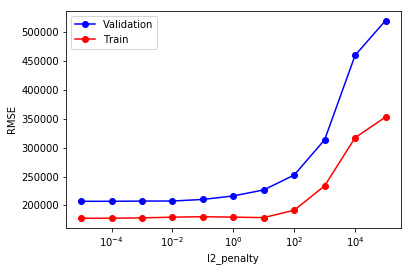

In [25]:
# Plot the validation RMSE as a blue line with dots
plt.plot(ridge_data['l2_penalty'], ridge_data['validation_rmse'], 
         'b-o', label='Validation')
# Plot the train RMSE as a red line dots
plt.plot(ridge_data['l2_penalty'], ridge_data['train_rmse'], 
         'r-o', label='Train')

# Make the x-axis log scale for readability
plt.xscale('log')

plt.xlabel('l2_penalty')
plt.ylabel('RMSE')
plt.legend()

Next, we want to actually look at which model we think will perform best. First we define a helper function that will be used to inspect the model parameters.

In [26]:
def print_coefficients(model, features):
    """
    This function takes in a model column and a features column. 
    And prints the coefficient along with its feature name.
    """
    feats = list(zip(model.coef_, features))
    print(*feats, sep = "\n")

In [48]:
# Print information about best L2 model
index = ridge_data['validation_rmse'].idxmin()
print(index)
row = ridge_data.loc[index]
best_model = row['model']
model_pred_test = best_model.predict(test[all_features])
mse_test = mean_squared_error(test['price'], model_pred_test)
print(sqrt(mse_test))
print_coefficients(best_model, all_features)

0
219058.6465957784
(472136.78051362094, 'bedrooms')
(-147215.17746054105, 'bedrooms_square')
(-345289.4359694263, 'bedrooms_sqrt')
(-1666200.6721926616, 'bathrooms')
(743358.0198025635, 'bathrooms_square')
(1013369.7872763008, 'bathrooms_sqrt')
(175766.76795942427, 'sqft_living')
(-162364.1199009171, 'sqft_living_square')
(-127415.12588032459, 'sqft_living_sqrt')
(-33220.27554241893, 'sqft_lot')
(66011.82397125017, 'sqft_lot_square')
(-27389.429093185197, 'sqft_lot_sqrt')
(-793813.6747535559, 'floors')
(160440.05736827725, 'floors_square')
(607321.6779313652, 'floors_sqrt')
(31094.203270227143, 'waterfront')
(31094.20409435073, 'waterfront_square')
(31094.204094350767, 'waterfront_sqrt')
(-1489.8130713501694, 'view')
(125074.07629372647, 'view_square')
(-52288.11284649475, 'view_sqrt')
(-60021.497875912304, 'condition')
(24008.721462498805, 'condition_square')
(36807.85186360909, 'condition_sqrt')
(-9226430.970643174, 'grade')
(3402457.856568074, 'grade_square')
(6010230.983416729, 'g

--- 
## LASSO Regression
In this section you will do basically the exact same analysis you did with Ridge Regression, but using LASSO Regression instead. Remember that for LASSO we choose the parameters that minimize this quality metric instead 

$$\hat{w}_{LASSO} = \min_w RSS(w) + \lambda \left\lVert w \right\rVert_1$$

where $\left\lVert w \right\rVert_1 = \sum_{j=0}^D \lVert w_j \rVert$ is the L1 norm of the parameter vector.


In [43]:
# Implement code to evaluate LASSO Regression with various L1 penalties
from sklearn.linear_model import Lasso

l1 = np.logspace(1, 7, num = 7)
dict2 = []

for i in range(0, len(l1)):
    model = Lasso(alpha=l1[i], random_state=0).fit(sales[all_features], sales['price'])
    model_pred_train = model.predict(train[all_features])
    model_pred_val = model.predict(validation[all_features])
    mse_train = mean_squared_error(train['price'], model_pred_train)
    mse_val = mean_squared_error(validation['price'], model_pred_val)
    dict2.append({'l1_penalty':l1[i], 'model':model, 'train_rmse':sqrt(mse_train), 'validation_rmse':sqrt(mse_val)})
    
lasso_data = pd.DataFrame(dict2)

C:\Users\Akshat\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Akshat\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,l1_penalty,model,train_rmse,validation_rmse
0,10.0,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",180827.503281,208840.514813
1,100.0,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",180377.178035,210471.281985
2,1000.0,"Lasso(alpha=1000.0, copy_X=True, fit_intercept...",179700.661568,219639.626035
3,10000.0,"Lasso(alpha=10000.0, copy_X=True, fit_intercep...",184731.672126,242596.439404
4,100000.0,"Lasso(alpha=100000.0, copy_X=True, fit_interce...",234670.119736,325240.775689


Like before, let's look at how the L1 penalty affects the performance.

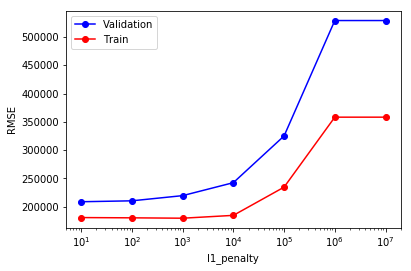

In [45]:
# Plot the validation RMSE as a blue line with dots

plt.plot(lasso_data['l1_penalty'], lasso_data['validation_rmse'],
         'b-o', label='Validation')

# Plot the train RMSE as a red line dots
plt.plot(lasso_data['l1_penalty'], lasso_data['train_rmse'],
         'r-o', label='Train')

# Make the x-axis log scale for readability
plt.xscale('log')

plt.xlabel('l1_penalty')
plt.ylabel('RMSE')
plt.legend()

In [47]:
# Print information about best L1 model
index = lasso_data['validation_rmse'].idxmin()
print(index)
row = lasso_data.loc[index]
best_model = row['model']
model_pred_test = best_model.predict(test[all_features])
mse_test = mean_squared_error(test['price'], model_pred_test)
print(sqrt(mse_test))
print_coefficients(best_model, all_features)

0
223307.3820954245
(-0.0, 'bedrooms')
(24790.738945834433, 'bedrooms_square')
(-38178.12012937558, 'bedrooms_sqrt')
(-447579.1170919289, 'bathrooms')
(360331.48283998517, 'bathrooms_square')
(170894.23464368057, 'bathrooms_sqrt')
(6726.870174369491, 'sqft_living')
(-11882.878814700576, 'sqft_living_square')
(309350.919806747, 'sqft_living_sqrt')
(24324.87277555819, 'sqft_lot')
(43823.20565998969, 'sqft_lot_square')
(-69332.55199736879, 'sqft_lot_sqrt')
(-79283.31999341624, 'floors')
(-39264.42648836552, 'floors_square')
(87214.34835788707, 'floors_sqrt')
(85474.9302766554, 'waterfront')
(4.953553163728055e-08, 'waterfront_square')
(8.446879165117142e-11, 'waterfront_sqrt')
(13527.337129543872, 'view')
(123477.79229015192, 'view_square')
(-67060.21018917013, 'view_sqrt')
(1763.9658753322747, 'condition')
(-6072.730562199572, 'condition_square')
(-207.30879678830684, 'condition_sqrt')
(159241.14145532495, 'grade')
(286387.9609690997, 'grade_square')
(-274510.5432577671, 'grade_sqrt')
(-